In [10]:
#imporint libraries
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap
import torch
from model.autoencoder import Autoencoder
import re

/home/nidham/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nidham/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nidham/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: Th

## Training the models
(skip to use the pretrained ones)

In [ ]:
!python train.py --num_epochs 10 --latent_size 256 --batch_size 128 --lr 0.0001

Setting paths and parameters

In [12]:
model_path2 = 'output/model_latent_size_2.pth'
model_path = 'output/model_latent_size_256.pth'
test_data = 'output/test_data.pth'
clusters = 43
latent_space = 'output/latent_space_size_256.npy'
num_samples = 1000

## Visualizing the constrction of the dataset

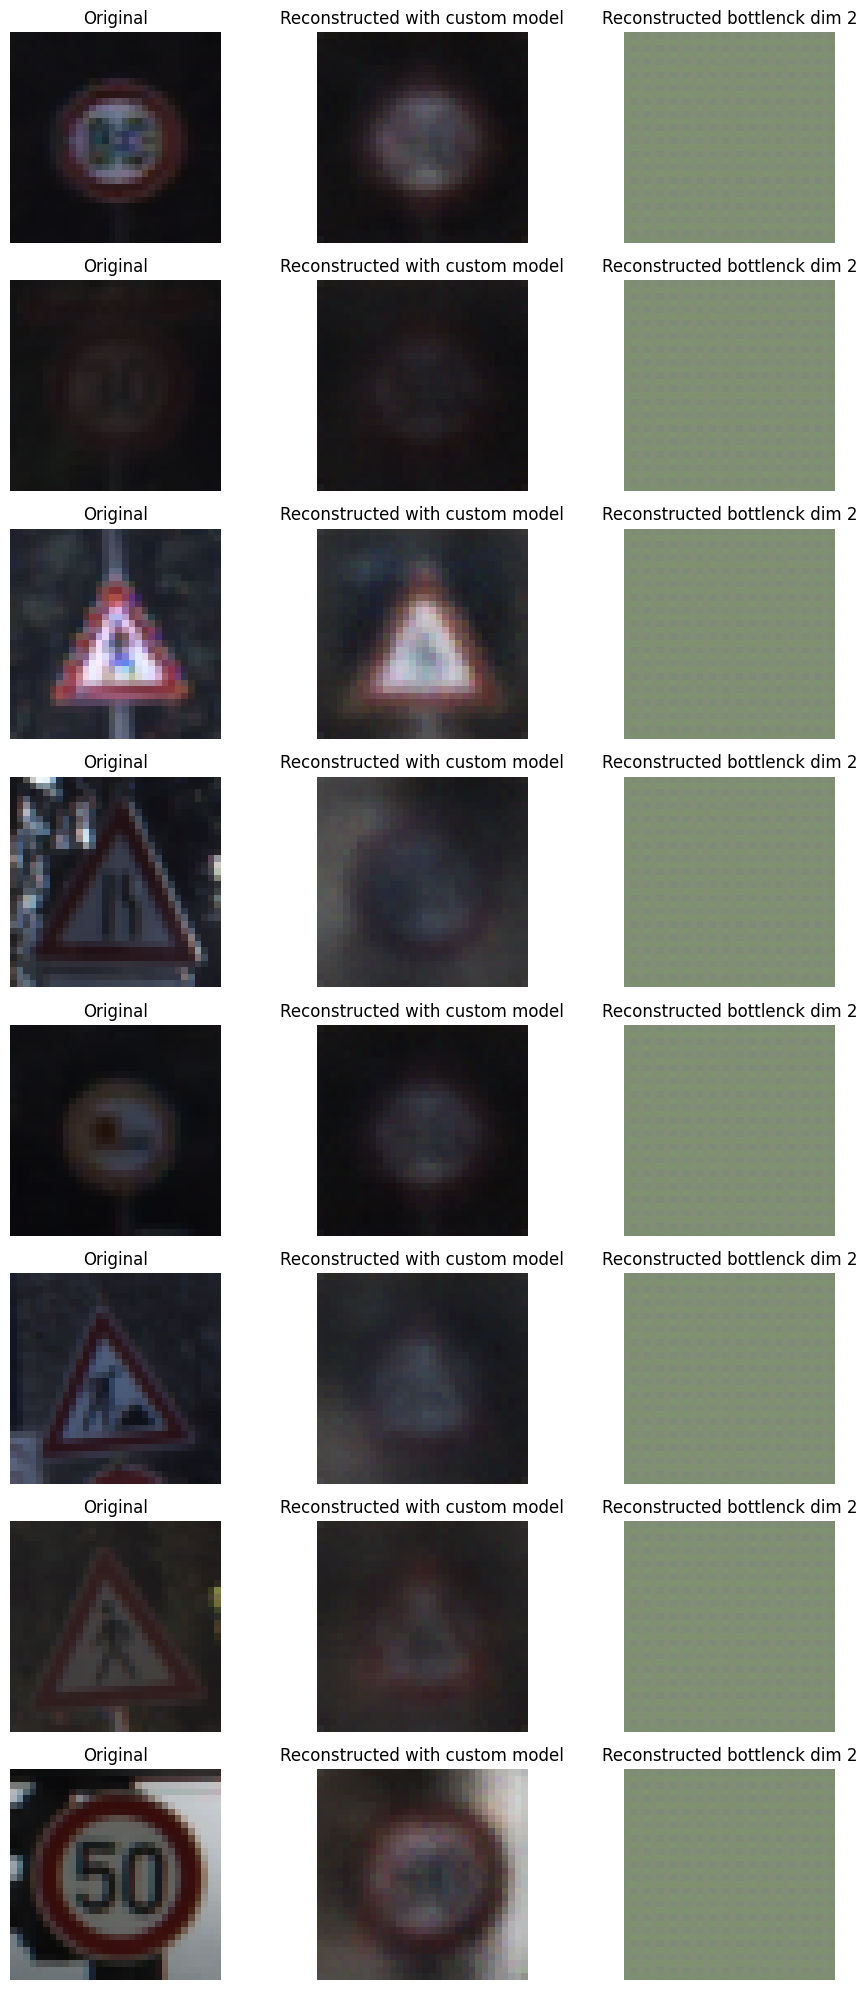

In [6]:



def extract_number(model_path):
    number = re.search(r"latent_size_(\d+)", model_path).group(1)
    return number

def viz_reconstructions(model_path, model_path2, test_data):

    # Load the trained models
    model1 = Autoencoder(int(extract_number(model_path))).to(device)
    model1.load_state_dict(torch.load(model_path))
    model1.eval()

    model2 = Autoencoder(2).to(device)
    model2.load_state_dict(torch.load(model_path2))
    model2.eval()

    # Load the test dataset
    test_dataset = torch.load(test_data)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

    # Get a batch of test images
    images, _ = next(iter(test_loader))
    images = images.to(device)

    # Reconstruct the images using model1
    with torch.no_grad():
        reconstructed1 = model1(images)

    # Reconstruct the images using model2
    with torch.no_grad():
        reconstructed2 = model2(images)

    # Convert the images to CPU and denormalize
    images = images.cpu().numpy() * 0.5 + 0.5
    reconstructed1 = reconstructed1.cpu().numpy() * 0.5 + 0.5
    reconstructed2 = reconstructed2.cpu().numpy() * 0.5 + 0.5

    # Display a batch of images and their reconstructions
    fig, axes = plt.subplots(8, 3, figsize=(10, 20))

    for i in range(8):
        # Original images
        axes[i, 0].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Original')

        # Reconstructed images from model1
        axes[i, 1].imshow(np.transpose(reconstructed1[i], (1, 2, 0)))
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Reconstructed with custom model')

        # Reconstructed images from model2
        axes[i, 2].imshow(np.transpose(reconstructed2[i], (1, 2, 0)))
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Reconstructed bottlenck dim 2')

    plt.tight_layout()
    plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
viz_reconstructions(model_path, model_path2, test_data)



## Encode n sample images from the dataset
(results saved as npy files in output folder)

In [9]:
!python encode_latent_space.py --model_path $model_path --test_data $test_data --num_samples $num_samples

Latent spaces representations saved successfully!


## Visualizing the encoded latent space with UMAP

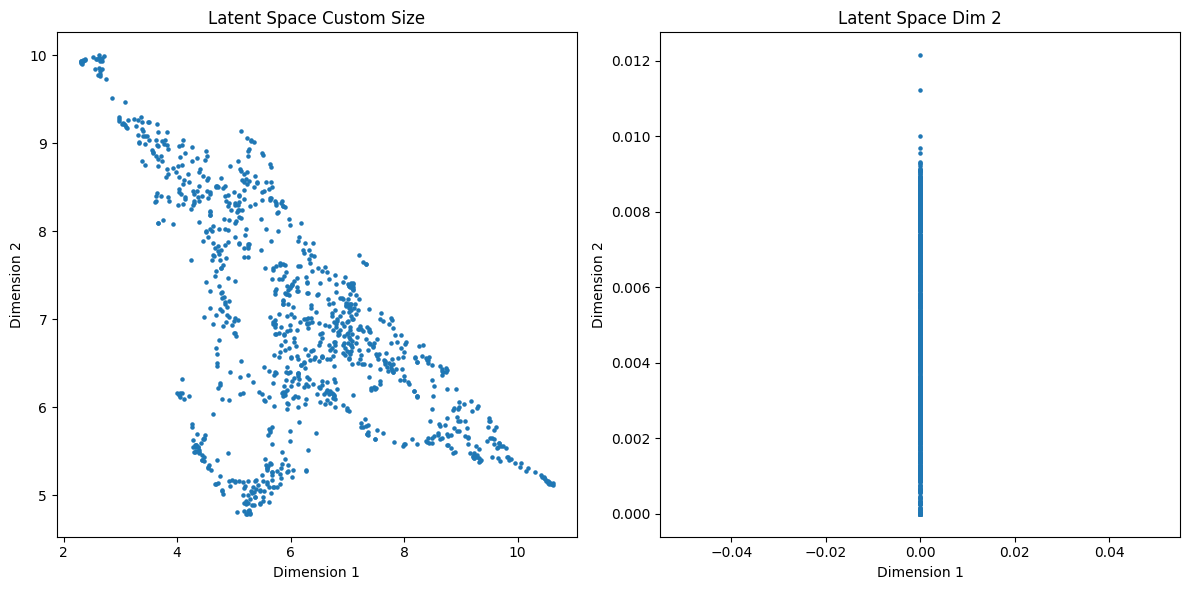

In [13]:
def umap_show(latent_space1, latent_space2):

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    titles = ['Latent Space Custom Size', 'Latent Space Dim 2']

    for i, latent_space in enumerate([latent_space1, latent_space2]):
        ax = axes[i]

        if i == 0:
            # Scale the latent space representations
            scaler = StandardScaler()
            latent_space_scaled = scaler.fit_transform(latent_space.reshape(latent_space.shape[0], -1))


            # Reduce dimensionality using PCA before applying UMAP
            pca = PCA(n_components=50)
            latent_space_pca = pca.fit_transform(latent_space_scaled)

            # Perform dimensionality reduction using UMAP
            reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42, n_components=50)
            embedding = reducer.fit_transform(latent_space_pca)

            # Visualize the latent space embeddings with UMAP
            ax.scatter(embedding[:, 0], embedding[:, 1], s=5)
        else:


            # Visualize the latent space embeddings with a scatter plot
            ax.scatter(latent_space[:, 0], latent_space[:, 1], s=5)

        ax.set_title(titles[i])
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')

    plt.tight_layout()
    plt.show()

latent_space_data = np.load(latent_space)
latent_space_light = np.load('output/latent_space_size_2.npy')

umap_show(latent_space_data, latent_space_light)

## Visualizing the encoded latent space with t-SNE

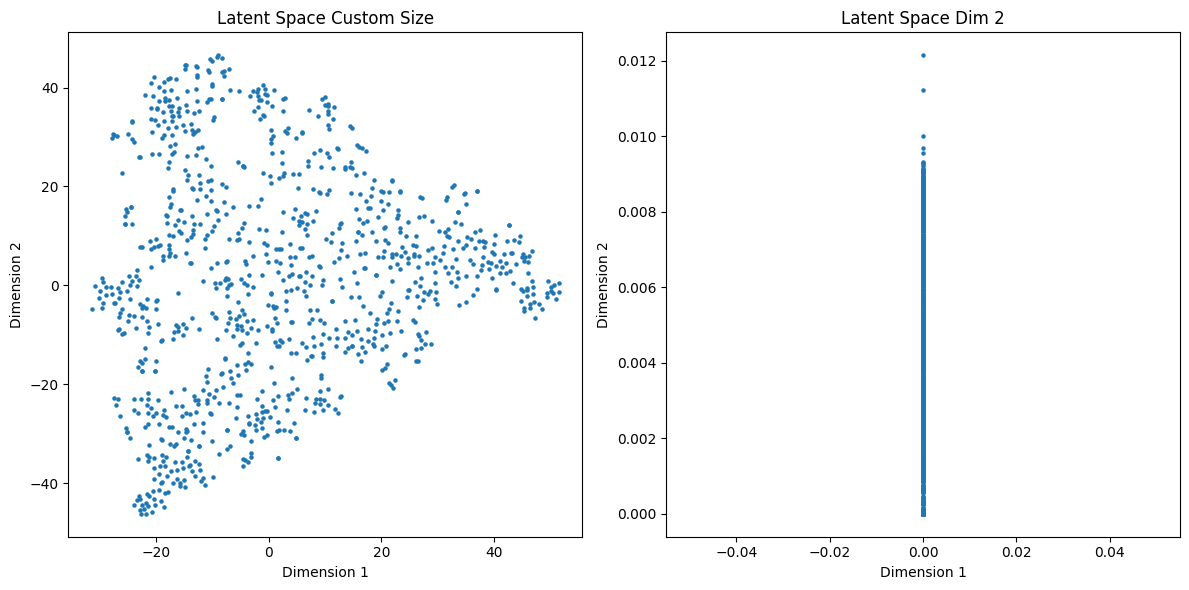

In [14]:
def tsne_show(latent_space1, latent_space2, n_components1=50, n_components2=8):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    titles = ['Latent Space Custom Size', 'Latent Space Dim 2']

    for i, latent_space in enumerate([latent_space1, latent_space2]):
        ax = axes[i]

        if i == 0:
            # Scale the latent space representations
            scaler = StandardScaler()
            latent_space_scaled = scaler.fit_transform(latent_space.reshape(latent_space.shape[0], -1))


            # Reduce dimensionality using PCA before applying t-SNE
            pca = PCA(n_components=50)
            latent_space_pca = pca.fit_transform(latent_space_scaled)

            # Perform dimensionality reduction using t-SNE
            reducer = TSNE(perplexity=30, n_iter=5000, random_state=42)
            embedding = reducer.fit_transform(latent_space_pca)

            # Visualize the latent space embeddings with t-SNE
            ax.scatter(embedding[:, 0], embedding[:, 1], s=5)
        else:

            # Visualize the latent space embeddings with a scatter plot
            ax.scatter(latent_space[:, 0], latent_space[:, 1], s=5)

        ax.set_title(titles[i])
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')

    plt.tight_layout()
    plt.show()

tsne_show(latent_space_data, latent_space_light)    

### Extra : kmeans clustering on reduced latent space

/home/nidham/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


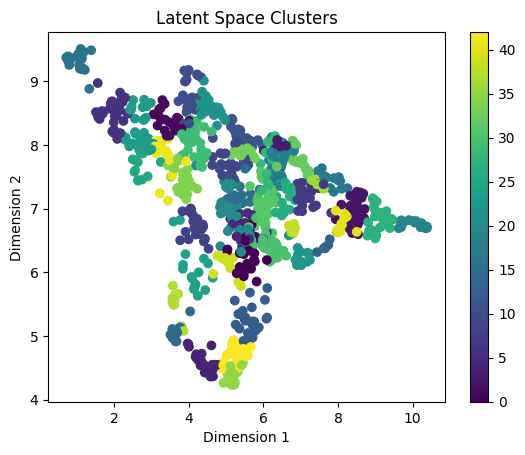

In [19]:
def visualize_clusters(latent_space, n_clusters):
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(latent_space)

    # Visualize the clusters in the latent space
    plt.scatter(latent_space[:, 0], latent_space[:, 1], c=cluster_labels, cmap='viridis')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Latent Space Clusters')
    plt.colorbar()
    plt.show()

scaler = StandardScaler()
latent_space_scaled = scaler.fit_transform(latent_space_data.reshape(latent_space_data.shape[0], -1))

            # Reduce dimensionality using PCA before applying UMAP
pca = PCA(n_components=50)
latent_space_pca = pca.fit_transform(latent_space_scaled)

            # Perform dimensionality reduction using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42, n_components=50)
embedding = reducer.fit_transform(latent_space_pca)    

visualize_clusters(embedding, clusters)